# **Multifractal Analysis on VMD Modes Using `pymultifracs` and `vmdpy`** 
### *Combining Variational Mode Decomposition with Wavelet-Based MFA*


Multifractal analysis (MFA) allows us to study the complex, scale-invariant structures present in real-world signals. While classical MFA is typically applied to full time series, this tutorial explores a **hybrid approach**: we first decompose a signal using **Variational Mode Decomposition (VMD)**, and then apply **wavelet-based multifractal analysis** to each extracted mode.

This method helps isolate the scale-free properties **mode by mode**, potentially improving interpretability and revealing **which components carry multifractal behavior**.


**🎯 Goal of This Tutorial**

- Generate or load a 1D signal (simulated or real).
- Decompose the signal into modes using **VMD**.
- Apply **wavelet-based MFA** to each individual mode using `pymultifracs`.
- Visualize and interpret the **multifractal spectra** of the modes.


In [1]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pymultifracs.utils import build_q_log
from pymultifracs.simul import mrw
from pymultifracs.wavelet import wavelet_analysis
from pymultifracs.mf_analysis import mfa
from sktime.libs.vmdpy import VMD
from scipy.signal import welch


gen_path = os.path.abspath(os.path.join(os.getcwd(), '..','03_signal_generation'))
sys.path.append(gen_path)

from sign_gen import generate_synthetic_neural_signal


# In simul => noisy => change mfa to mf_analysis
# change the import of wavelet_analysis to wavelet in the noisy script and others locations

## 🔹 Step 1: Generate a Synthetic Signal
Before applying multifractal analysis, we start by creating a synthetic signal composed of both structured and random components. This allows us to test the VMD+MFA pipeline in a controlled setting.

📌 **Goal:** Generate synthetic multifractal signals to analyze.  
📌 **Why?** This allows us to test the multifractal analysis (MFA) methods on controlled data.  
📌 **Key output:** A 2D array of time series (shape: *(N_samples, N_realizations)*).  

In [2]:
# 1. Pure Oscillations
pure = generate_synthetic_neural_signal(
    mode="basic",
    add_one_over_f=False,
    add_powerline=False
)

# 2. Oscillations + 1/f Noise
pure_with_noise = generate_synthetic_neural_signal(
    mode="basic",
    add_one_over_f=True,
    add_powerline=False
)

# 3. MRW Modulated Oscillations (No Noise)
mrw_modulated = generate_synthetic_neural_signal(
    mode="realistic",
    c1=0.2,
    c2=-0.15,
    add_one_over_f=False,
    add_powerline=False
)

# 4. MRW + 1/f Noise
mrw_modulated_with_noise = generate_synthetic_neural_signal(
    mode="realistic",
    c1=0.2,
    c2=-0.15,
    add_one_over_f=True,
    add_powerline=False
)


# 4. MRW (with H and L) + 1/f Noise
mrwH_modulated_with_noise = generate_synthetic_neural_signal(
    mode="realistic",
    lam = np.sqrt(.05), 
    H=0.8,
    add_one_over_f=True,
    add_powerline=False
)


Generating MRW with c1, c2, L using mrw_cumul()
Generating MRW with c1, c2, L using mrw_cumul()
Generating MRW with H, lam, L using mrw()


In [3]:
def plot_signals(signal_dicts, titles, fs=250, duration=2.0):
    """
    Plots multiple signals for comparison.

    Parameters:
    - signal_dicts: list of dictionaries containing signal data.
    - titles: list of plot titles.
    - fs: sampling frequency.
    - duration: duration in seconds to plot.
    """
    n_samples_to_plot = int(fs * duration)
    t = signal_dicts[0]['time'][:n_samples_to_plot]
    
    plt.figure(figsize=(15, 10))
    for i, (signal_dict, title) in enumerate(zip(signal_dicts, titles)):
        plt.subplot(len(signal_dicts), 1, i + 1)
        plt.plot(t, signal_dict['final_signal'][:n_samples_to_plot])
        plt.title(title)
        plt.ylabel("Amplitude")
        if i == len(signal_dicts) - 1:
            plt.xlabel("Time (s)")
    plt.tight_layout()
    plt.show()


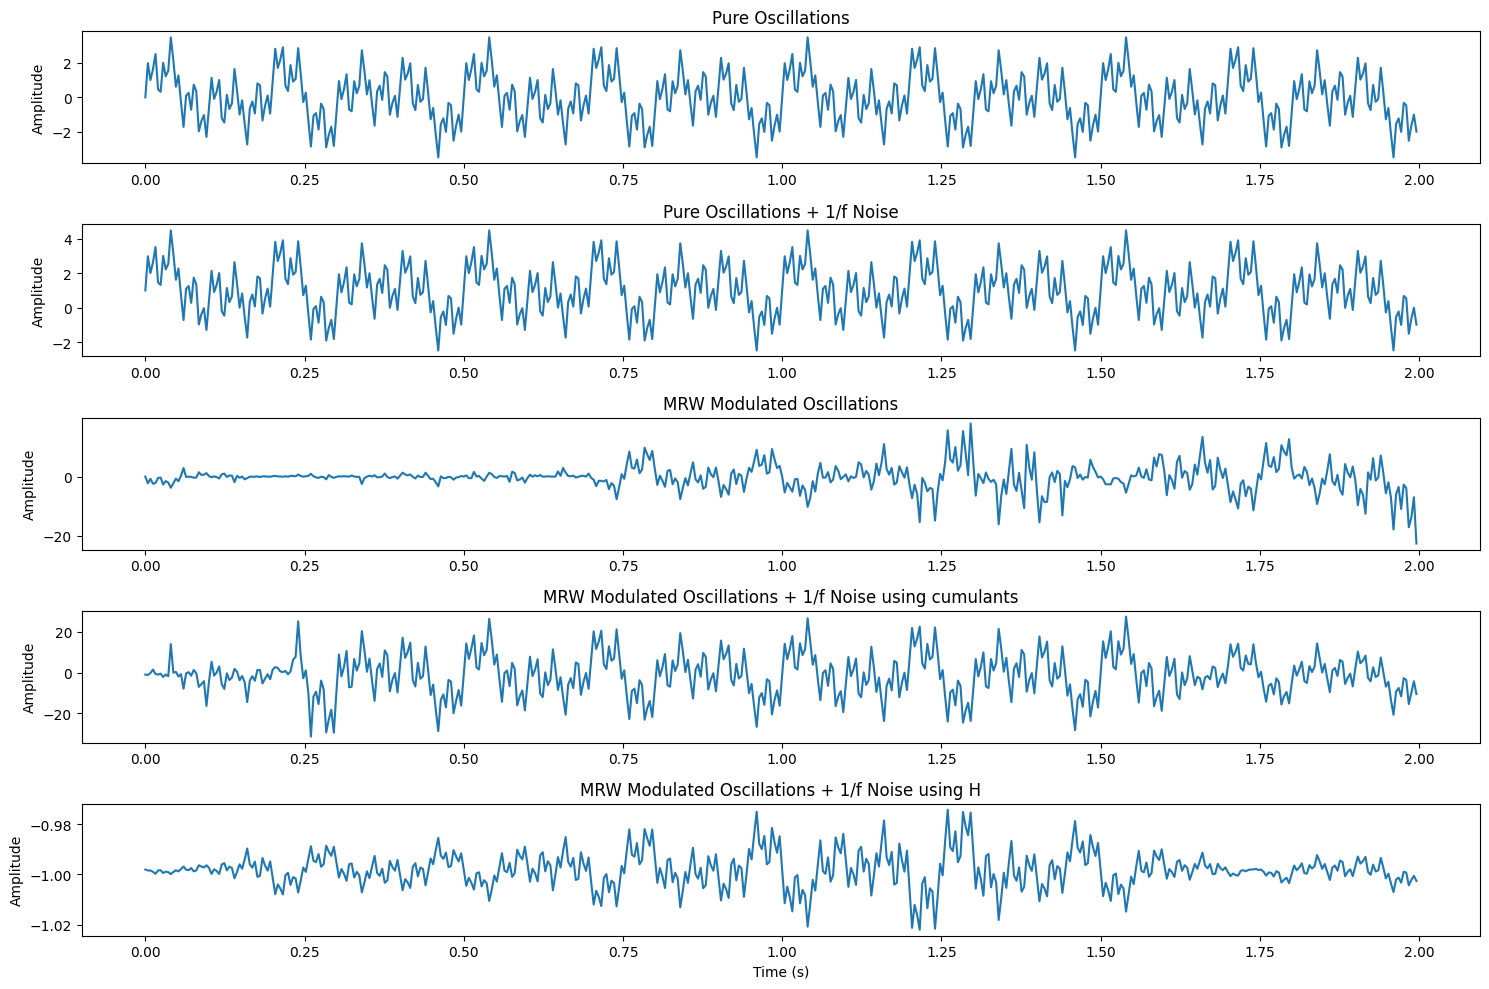

In [4]:
# Call plotting function with your signals
plot_signals(
    [pure, pure_with_noise, mrw_modulated, mrw_modulated_with_noise,mrwH_modulated_with_noise],
    ["Pure Oscillations",
     "Pure Oscillations + 1/f Noise",
     "MRW Modulated Oscillations",
     "MRW Modulated Oscillations + 1/f Noise using cumulants",
     "MRW Modulated Oscillations + 1/f Noise using H"]
)


## 🔹 Step 2: Multifractal Analysis of the Full Signal

Before decomposing the signal into modes, we first apply **Multifractal Analysis (MFA)** directly to the full signal. This gives us a **global multifractal signature** that we'll later compare to the individual VMD modes.

We use the `pymultifracs` library, which relies on **wavelet p-leaders** to perform a robust estimation of multifractal properties.

Here's what happens step-by-step:

1. **Wavelet Transform**  
   We compute the discrete wavelet transform of the signal using the `db3` wavelet. This step captures local fluctuations at multiple scales.

2. **Compute Wavelet p-Leaders**  
   Instead of raw coefficients, we use p-leaders (with exponent `p=2`), which provide a more stable way to estimate local regularity and are better suited for multifractal analysis.

3. **Integration over Scale Ranges**  
   We select the scales `[6, 11]` as the range for multifractal estimation. These are empirically chosen and should be adapted based on signal length and content.

4. **Run Multifractal Regression**  
   We estimate the **scaling function** ζ(q), the **log-cumulants** (c₁, c₂, ...), and the **singularity spectrum** D(h).

📌 **Why this matters:**  
Performing MFA on the full signal allows us to assess:
- Whether the original signal is multifractal (nonlinear ζ(q), negative c₂, wide D(h))
- How this global signature changes when analyzed mode-by-mode

📌 **Key outputs:**
- **ζ(q):** Shows how moments of the signal scale across resolutions
- **Log-cumulants:** Compact representation of multifractal behavior (c₂ < 0 suggests multifractality)
- **D(h) spectrum:** Distribution of local regularity (wider = more complex)

This analysis forms our **baseline** before decomposition.


In [ ]:
# Define the scaling ranges for analysis
#scaling_ranges = [(2, 8), (3, 8)]
#scaling_ranges = [[8, 12]]  # A narrower range
scaling_ranges = [[6, 11]]

In [ ]:
WT = wavelet_analysis(X, wt_name='db3')
WTpL = WT.get_leaders(p_exp=2)
WTpL = WTpL.auto_integrate(scaling_ranges)
#pwt = mfa(WTpL, scaling_ranges, q=[-2, -1, 0, 1, 2])
pwt = mfa(WTpL, scaling_ranges, weighted='Nj', q=build_q_log(.1, 5, 20))


# Plot ζ(q)
pwt.structure.plot_scaling()
plt.title(f"ζ(q) for The Original Signal")
plt.show()

# Plot cumulants
pwt.cumulants.plot()
plt.title(f"Cumulants for The Original Signal")
plt.show()

# Plot D(h)
pwt.spectrum.plot()
plt.title(f"D(h) Spectrum for the Original Signal")
plt.show()

## 🔹 Step 3: Interpreting the Multifractal Analysis of the Original Signal

### 1. Scaling Function ζ(q)

The scaling function ζ(q) describes how the statistical moments of the signal behave across different time scales. In simpler terms, it shows **how patterns in the signal change depending on how "zoomed in" or "zoomed out" you are**.

- A **perfectly straight ζ(q)** line means the signal is *monofractal* (all parts behave similarly).
- A **curved ζ(q)** line, like the one we observe, indicates **multifractality**: different parts of the signal behave differently across scales.

In our case, ζ(q) is slightly **nonlinear**, which means:
> ➤ The signal exhibits **heterogeneous temporal structure**: some parts are smooth, others are more irregular, and these patterns persist across scales.


### 2. Log-Cumulants: c₁ and c₂

The log-cumulants summarize the shape of ζ(q) mathematically.

- **c₁ (≈ 0.83)**: This value reflects the **average local regularity** in the signal. A value near 0.8 suggests the signal is **fairly smooth**, with moderately regular transitions.
  
- **c₂ (≈ -0.03)**: This captures the **width of the multifractal spectrum** — in other words, how much variability there is in the signal's structure.  
  A **negative value of c₂**, indicates **multifractality**. The more negative, the richer the range of fluctuations.

In our case:
> ➤ The signal contains **structured variability** — but with **modest complexity**.


### 3. Multifractal Spectrum D(h)

The D(h) spectrum provides a visual summary of **how many different types of local behavior (regularities) exist** in the signal.

- The x-axis (h) represents **local regularity**: low h = sharp changes, high h = smoother regions.
- The y-axis (D(h)) tells us **how frequent** each regularity is.

In our plot:
- The spectrum is **broad**, ranging from about 0.4 to 1.0.
- This suggests a **mixture of both smooth and irregular regions** in the signal.
- The peak of D(h) is near 1, meaning that **most of the signal is relatively smooth**, but **less regular fragments also exist**.

> ➤ The signal’s behavior **varies locally**, showing a **diversity of temporal dynamics**.  
> ➤ This is typical of biological signals like EEG or fMRI, which combine regular rhythms with bursts of irregularity.



Even when the differences are subtle (as here), **multifractal analysis captures patterns that simpler methods may miss.**


# 🔹 Step 4: Decompose the Signal Using VMD

We apply VMD to split the signal into \( K \) modes, each corresponding to a specific frequency band. This helps isolate components that may carry distinct dynamical features.

VMD is a modern alternative to Empirical Mode Decomposition (EMD), formulated as a **variational optimization problem**. Unlike EMD, VMD:
- Is based on solid mathematical principles
- Is non-recursive and avoids mode mixing
- Decomposes the signal by minimizing the total bandwidth of each mode


### How VMD Works (Intuition)

VMD assumes that a signal is composed of multiple **amplitude- and frequency-modulated oscillatory components**.  
It aims to find a set of modes \( u_k(t) \) and their associated center frequencies \( \omega_k \) such that:

1. Each mode has **limited bandwidth** in the frequency domain
2. The sum of all modes reconstructs the original signal
3. The total bandwidth across modes is minimized (regularization)

This is solved using the **Alternating Direction Method of Multipliers (ADMM)** to iteratively update both the modes and their frequencies.

📌 **Why this matters:**

By applying VMD to a multifractal signal like an MRW, we can:
- See how complexity is distributed across frequency bands
- Apply MFA to each mode independently
- Explore whether **multifractality is global or localized** to specific components

Below are the key parameters used in the decomposition, with their roles:

| Parameter | Meaning |
|-----------|---------|
| `alpha`   | **Bandwidth constraint**. Controls how narrow each mode should be in frequency. Larger values enforce tighter frequency localization. |
| `tau`     | **Noise-tolerance** level. A value of `0.` assumes a perfectly noiseless signal; higher values allow looser reconstruction. |
| `K`       | **Number of modes** to extract. This determines how many distinct components the signal will be split into. |
| `DC`      | **DC component inclusion**. If `1`, one mode is fixed to zero frequency (for extracting a trend or baseline); if `0`, no such constraint. |
| `init`    | **Initialization method** for center frequencies. `1` = uniformly distributed, `0` = all at zero. |
| `tol`     | **Convergence tolerance**. Determines when the algorithm should stop iterating. Smaller values lead to more precise convergence, but longer computation. |


In [ ]:
signal = X[:, 0]   # Extract the 1D array
N = len(signal)
frequencies = np.fft.fftshift(np.fft.fftfreq(N, d=1/N)) * 2 * np.pi
signal_fft = np.fft.fftshift(np.fft.fft(signal))
colors = ['b', 'g', 'm', 'c', 'r', 'y', 'k']  


alpha = 2000       
tau = 0.            
K = 3               
DC = 0              
init = 1            
tol = 1e-7          

u, u_hat, omega = VMD(signal, alpha, tau, K, DC, init, tol)

# Sort modes by increasing final frequency
sortIndex = np.argsort(omega[-1, :])
omega = omega[:, sortIndex]
u_hat = u_hat[:, sortIndex]
u = u[sortIndex, :]

In [ ]:
print("Shape of u (time-domain modes):", u.shape)
print("Shape of u_hat (frequency-domain modes):", u_hat.shape)
print("Shape of omega (center frequencies over iterations):", omega.shape)

### 1. Interpretation of VMD Modes:

In [ ]:
plt.figure(figsize=(10, 4))
for k in range(K):
    plt.plot(u[k, :], color=colors[k % len(colors)], label=f"Mode {k+1}")
plt.title("Decomposed Modes from MRW Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, K*2))
for k in range(K):
    plt.subplot(K, 1, k + 1)
    plt.plot(u[k, :], color=colors[k % len(colors)])
    plt.title(f"Decomposed Mode {k+1}")
    plt.xlim(0, N)
plt.tight_layout()
plt.show()


**Mode 1 (Blue):**  
Smooth and slowly varying — captures low-frequency trends or baseline activity.

**Mode 2 (Green):**  
Moderate oscillations — represents mid-frequency dynamics or structured fluctuations.

**Mode 3 (Magenta):**  
Fast, noisy variations — isolates high-frequency content and fine-scale irregularities.

These modes reflect different frequency bands of the original MRW signal, and are well-separated.  

### 2. Interpretation of Spectral Decomposition:

In [ ]:
plt.figure()
plt.loglog(frequencies[N//2:], np.abs(signal_fft[N//2:]), 'k:', label='Original')
for k in range(K):
    plt.loglog(frequencies[N//2:], np.abs(u_hat[N//2:, k]),
               color=colors[k % len(colors)], label=f'Mode {k+1}')
plt.xlim([frequencies[N//2], frequencies[-1]])
plt.xlabel("Frequency (rad/s)")
plt.ylabel("Amplitude (log scale)")
plt.title("Spectral Decomposition")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This log-log plot shows the **power spectrum** of the original signal and its VMD modes:

- **Black dotted line (Original):**  
  The full signal spans a wide range of frequencies, confirming its complex, scale-free nature.

- **Blue (Mode 1):**  
  Dominates low frequencies — consistent with a slow, smooth trend.

- **Green (Mode 2):**  
  Peaks in mid frequencies — captures structured, oscillatory components.

- **Magenta (Mode 3):**  
  Concentrated in high frequencies — isolates fast, noisy fluctuations.

Each mode is **well-localized in a different frequency band**.

### 3. Interpretation of the Frequencies Evolution:

In [ ]:
fs = 1 / N  # Sampling frequency approximation

plt.figure(figsize=(8, 4))
for k in range(K):
    plt.semilogx(2 * np.pi / fs * omega[:, k],
                 np.arange(1, omega.shape[0] + 1),
                 color=colors[k % len(colors)],
                 label=f"Mode {k+1}")
plt.title("Evolution of Center Frequencies ωₖ (VMD iterations)")
plt.xlabel("Frequency (rad/s)")
plt.ylabel("Iteration")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


This graph shows how the center frequency of each mode evolves over time (iteration after iteration) during the VMD optimization process.

Each colored line is one mode:

Blue = Mode 1
⟶ quickly locks into a very low frequency → a slow trend

Green = Mode 2
⟶ stabilizes around middle frequencies

Magenta = Mode 3
⟶ converges to a high frequency

### 4. Interpretation of Power Spectrum via Welch PSD:

In [ ]:
# Welch PSD (in Hz, true PSD with smoothing)
plt.figure(figsize=(10, 5))
for k in range(K):
    f_welch, Pxx = welch(u[k, :], fs=1.0, nperseg=1024)
    plt.semilogy(f_welch, Pxx, color=colors[k % len(colors)], label=f"Mode {k+1}")
plt.title("Mode Spectra via Welch PSD")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power / Hz")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


- **Mode 1 (Blue)**:  
  This mode has a **high amplitude at low frequencies**, indicating that it captures **slow oscillations** (like a trend or drift).

- **Mode 2 (Green)**:  
  This mode captures **oscillations at mid-range frequencies**, with a **moderate decay** of power as the frequency increases.

- **Mode 3 (Magenta)**:  
  This mode is concentrated at **higher frequencies**, representing **fast oscillations** or fine details of the signal.

Each mode extracts a **distinct frequency range**, showing that the VMD decomposition has successfully separated the components of the signal.

### 5. Interpretation of the orrelation Between Modes (Time Domain)

In [ ]:
df = pd.DataFrame(u.T, columns=[f'Mode {i+1}' for i in range(K)])
corr_matrix = df.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Between Modes (Time Domain)")
plt.show()


- **Mode 1 vs Mode 2 (0.042)**: Very **low correlation**, indicating that these modes are almost **independent** of each other in the time domain.

- **Mode 1 vs Mode 3 (0.004)**: Extremely **low correlation**, showing no significant relationship, which makes sense as Mode 1 captures **slow components**, while Mode 3 captures **high-frequency details**.

- **Mode 2 vs Mode 3 (0.1)**: **Slight positive correlation**, indicating a small relationship but still mostly **independent**.

The low correlation values suggest that the VMD has successfully decomposed the signal into distinct, independent modes.

## 🔹 Step 5: Multifractal Analysis (MFA) on VMD Modes

In this step, we apply **Multifractal Analysis (MFA)** to the modes extracted from the **Variational Mode Decomposition (VMD)**. This allows us to analyze the **multifractal properties** of each mode separately, which helps us understand the **different dynamics** captured by each mode.

In [ ]:
colors = ['b', 'g', 'm', 'c', 'r', 'y', 'k']  # Change if needed

# -------------------------
# 1. Apply wavelet transform on each mode
# -------------------------
for k in range(K):
    # Compute the discrete wavelet transform (DWT) for each mode
    WT = wavelet_analysis(u[k, :], wt_name='db3')  # 'db3' is Daubechies wavelet
    
    # -------------------------
    # 2. Compute wavelet p-leaders
    # -------------------------
    WTpL = WT.get_leaders(p_exp=2)  # p_exp=2 is a common choice for multifractal analysis
    
    # -------------------------
    # 3. Integrate over scaling range
    # -------------------------
    # Select scale range [6, 11] for analysis (change as needed)
    WTpL = WTpL.auto_integrate(scaling_ranges)  
    
    # -------------------------
    # 4. Perform multifractal regression
    # -------------------------
    #pwt = mfa(WTpL, scaling_ranges=[[6, 11]], q=[-2, -1, 0, 1, 2])  # q values define the multifractal spectrum
    pwt = mfa(WTpL, scaling_ranges, weighted='Nj', q=build_q_log(.1, 5, 20))

    # -------------------------
    # 5. Plot results
    # -------------------------
    plt.figure(figsize=(10, 5))
    pwt.structure.plot_scaling()
    plt.title(f"ζ(q) for Mode {k+1}")
    plt.show()

    # Plot log-cumulants
    plt.figure(figsize=(10, 5))
    pwt.cumulants.plot()
    plt.title(f"Cumulants for Mode {k+1}")
    plt.show()

    # Plot D(h) spectrum
    plt.figure(figsize=(10, 5))
    #plt.xlim([1, 10**5])  # Expanding the frequency range to give more space
    pwt.spectrum.plot()
    plt.title(f"D(h) Spectrum for Mode {k+1}")
    plt.show()
